<a href="https://colab.research.google.com/github/Selva-Subramanian/Yes-Bank-Stock-Closing-Price-Prediction/blob/main/Yes_Bank_Stock_Closing_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem Statement**

Yes Bank is a well-known bank in the Indian financial domain. Since 2018, it has been in the
news because of the fraud case involving Rana Kapoor. Owing to this fact, it was interesting
to see how that impacted the stock prices of the company and whether Time series models
or any other predictive models can do justice to such situations. This dataset has monthly
stock prices of the bank since its inception and includes closing, starting, highest, and lowest
stock prices of every month. The main objective is to predict the stock’s closing price of the
month.

In [69]:
# mount drive to load dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [319]:
# importing the required libraries
import warnings                                        # do not disturb mode
warnings.filterwarnings('ignore')

import numpy as np                                     # vectors and matrices
import pandas as pd                                    # tables and data manipulations
import matplotlib.pyplot as plt                        # plots
import seaborn as sns
import plotly.express as px                       

from datetime import datetime                          # to convert to date
from statsmodels.tsa.arima_model import ARIMA          # to build ARIMA
from fbprophet import Prophet                          # to build prophet

from dateutil.relativedelta import relativedelta       # working with dates with style
from scipy.optimize import minimize                    # for function minimization

from sklearn.preprocessing import (MinMaxScaler,       # scale the data
StandardScaler)         

from sklearn.model_selection import train_test_split   # splitting train and test data
from sklearn.model_selection import (cross_val_score,  # splitting train and test data on a timeseries
TimeSeriesSplit)
from sklearn.linear_model import LinearRegression      # regression model
from xgboost import XGBRegressor                       # xgboost model
from sklearn.linear_model import (Lasso, Ridge,        # regularization
ElasticNet, LassoCV, RidgeCV, ElasticNetCV)
from sklearn.model_selection import GridSearchCV       # grid search to optimize parameters

from sklearn.metrics import (r2_score,                 # import required metrics
mean_squared_error,  mean_absolute_percentage_error, mean_absolute_error)

from statsmodels.tsa.stattools import adfuller         # statistics and econometrics
import statsmodels.formula.api as smf                  
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                          # some useful functions
from tqdm import tqdm_notebook



%matplotlib inline

In [320]:
# load the dataset
working_dir_path = "/content/drive/MyDrive/Colab Notebooks/AlmaBetter Notebooks/Capstone projects/Yes Bank Stock Closing Price Prediction - Selva Subramanian S/"
df = pd.read_csv(working_dir_path + "data_YesBank_StockPrices.csv")

In [321]:
df.head()

,Date,Open,High,Low,Close
0,Jul-05,13.00,14.00,11.25,12.46
1,Aug-05,12.58,14.88,12.55,13.42
2,Sep-05,13.48,14.87,12.27,13.30
3,Oct-05,13.20,14.47,12.40,12.99
4,Nov-05,13.35,13.88,12.88,13.41


In [322]:
df.shape

(185, 5)

In [323]:
df.describe()

,Open,High,Low,Close
count,185.000000,185.000000,185.000000,185.000000
mean,105.541405,116.104324,94.947838,105.204703
std,98.879850,106.333497,91.219415,98.583153
min,10.000000,11.240000,5.550000,9.980000
25%,33.800000,36.140000,28.510000,33.450000
50%,62.980000,72.550000,58.000000,62.540000
75%,153.000000,169.190000,138.350000,153.300000
max,369.950000,404.000000,345.500000,367.900000


In [324]:
# let's look at the details of our features 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    185 non-null    object 
 1   Open    185 non-null    float64
 2   High    185 non-null    float64
 3   Low     185 non-null    float64
 4   Close   185 non-null    float64
dtypes: float64(4), object(1)
memory usage: 7.4+ KB


*  We have a total of 185 entries. <br>
*  No null values. <br>
*  Date column is of 'object' datatype we have to convert it to 'datetime'.


In [325]:
# convert string object to datetime object
df['Date'] = df['Date'].apply(lambda x: datetime.strptime(x, "%b-%y"))

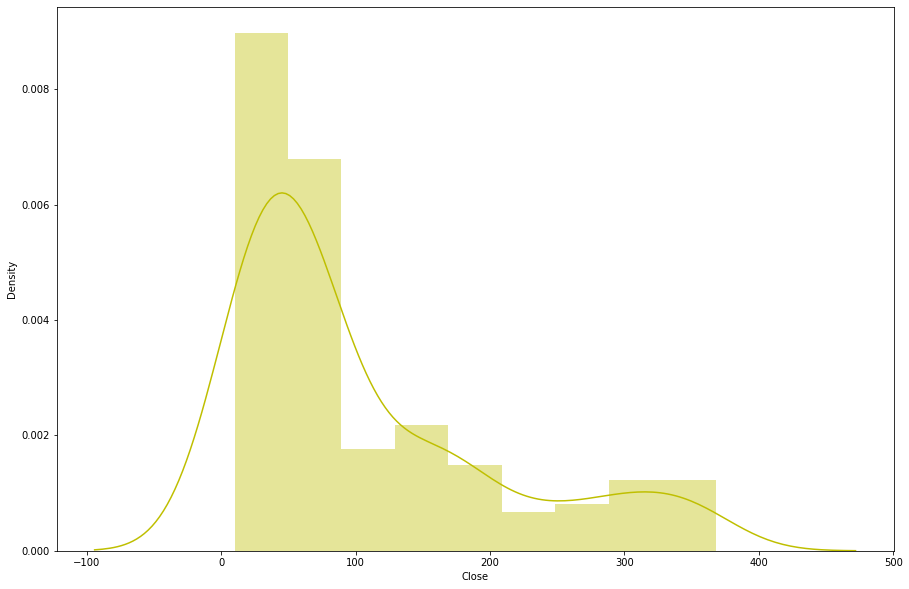

In [340]:
# Dependent variable 'Closing price'
plt.figure(figsize=(15,10))
sns.distplot(df['Close'],color="y")

In [328]:
# let's visualise the data
fig = px.line(df, df['Date'], df['Close'], title='Monthly closing price', template = 'plotly_dark')
fig.update_layout(
    xaxis=dict(title='Year'),
    yaxis=dict(title='Closing price'),
    autosize=False,
    width=1400,
    height=400)

fig.show()

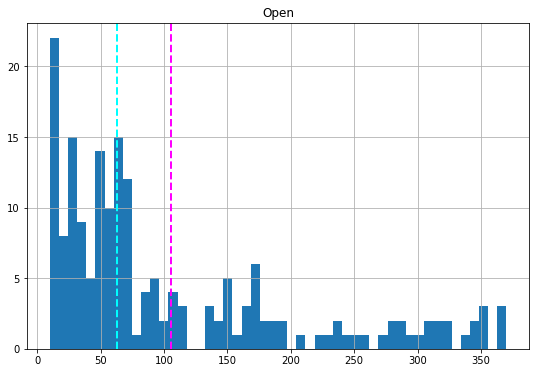

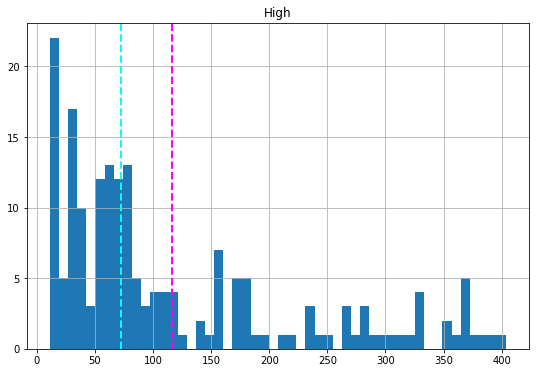

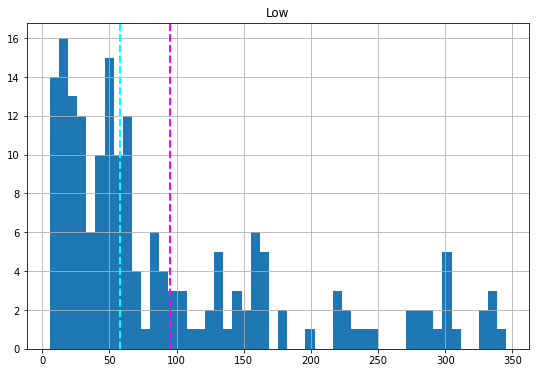

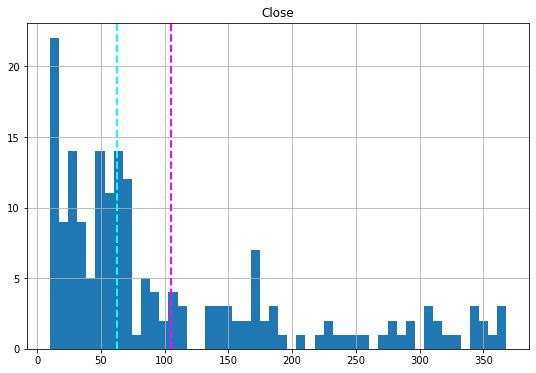

In [347]:
# Check for skewness in the dataset

numeric_features = df.describe().columns

for col in numeric_features[0:4]:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = df[col]
    feature.hist(bins=50, ax = ax)
    ax.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
    ax.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)    
    ax.set_title(col)
plt.show()

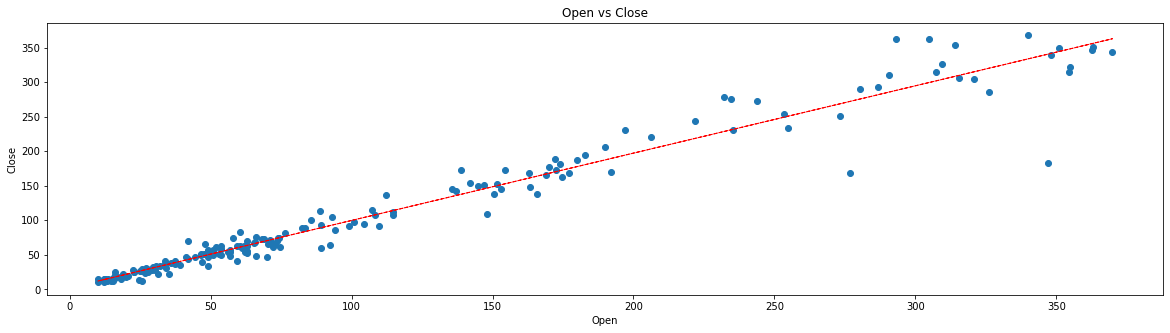

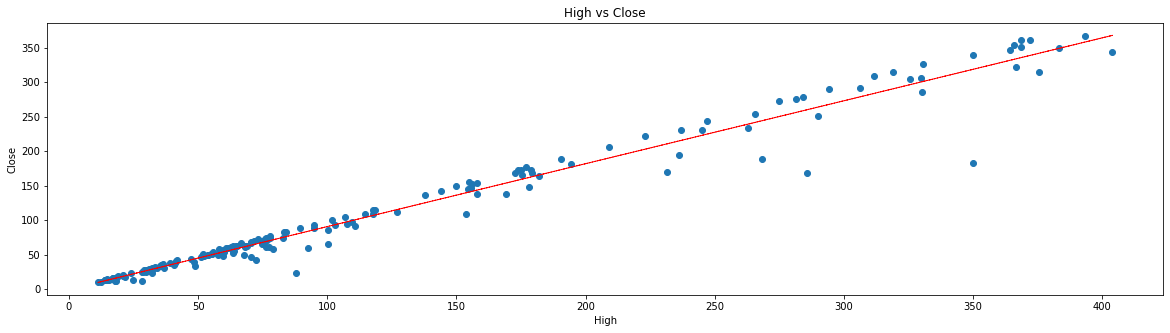

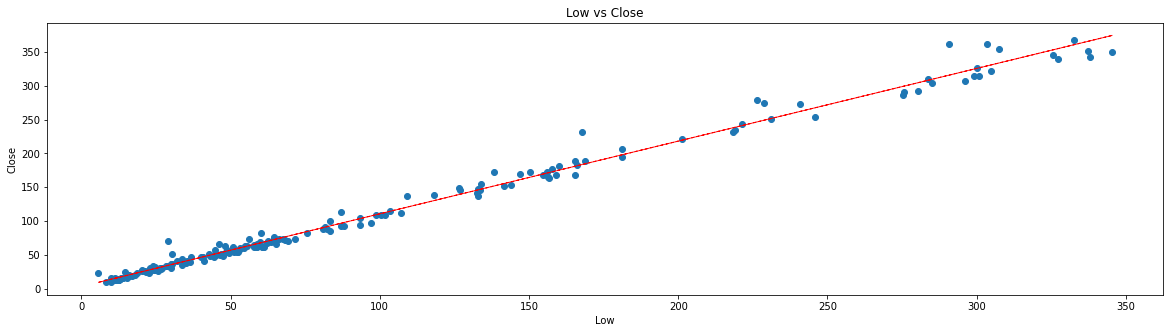

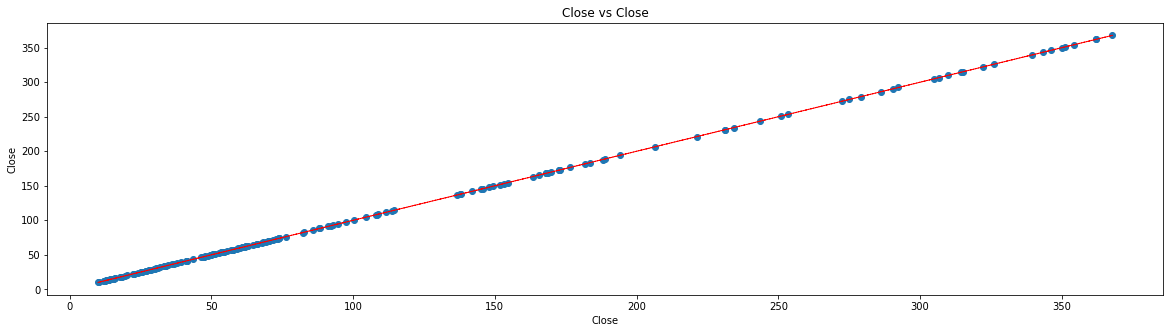

In [348]:
# scatter plot to see the relationship between dependent & independent variables

for col in df.describe().columns[:-1]:
  fig = plt.figure(figsize=(20,5))
  ax = fig.gca()
  plt.scatter(df[col], df['Close'])
  plt.xlabel(col)
  plt.ylabel('Close')
  ax.set_title('{} vs Close'.format(col))
  z = np.polyfit(df[col], df['Close'], 1)
  y_hat = np.poly1d(z)(df[col])
  plt.plot(df[col], y_hat, "r--", lw=1)
  plt.show()

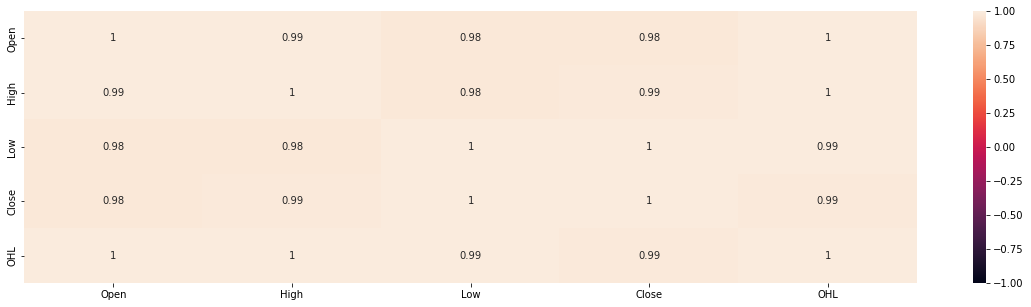

In [349]:
# let's see if corelation exists

plt.figure(figsize=(20,5))
cor = sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap=None, annot=True )

### Every feature is extremely corelated with each other, so taking just one feature or average of these features would suffice for our regression model as linear regression assumes there is no multi colinearity in the features.

In [350]:
# Creating a new feature based on average of other features in the dataset

df['OHL'] = df[['Open', 'High', 'Low']].mean(axis=1).round(2)
df.head()

,Date,Open,High,Low,Close,OHL
0,2005-07-01,13.00,14.00,11.25,12.46,12.75
1,2005-08-01,12.58,14.88,12.55,13.42,13.34
2,2005-09-01,13.48,14.87,12.27,13.30,13.54
3,2005-10-01,13.20,14.47,12.40,12.99,13.36
4,2005-11-01,13.35,13.88,12.88,13.41,13.37


### Linear regression also assumes a linear relationship between the target variables and independent variables, let's check if such relationship exists through a scatter plot

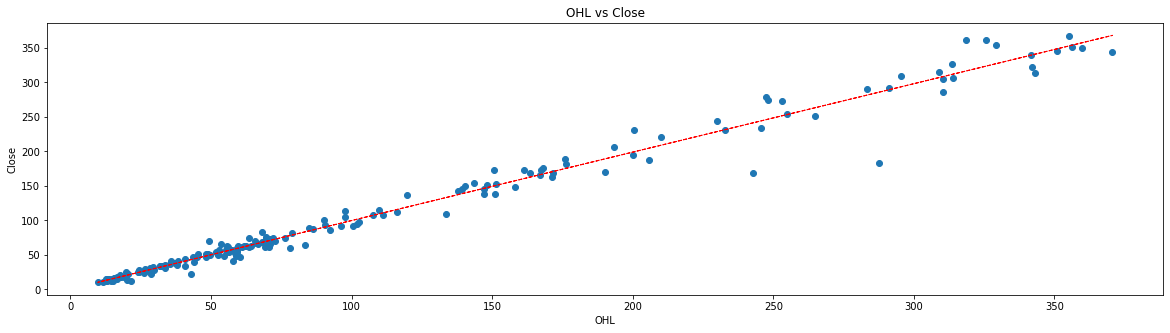

In [351]:
# scatter plot to see the relationship between dependent & independent variables

fig = plt.figure(figsize=(20,5))
ax = fig.gca()
plt.scatter(df['OHL'], df['Close'])
plt.xlabel('OHL')
plt.ylabel('Close')
ax.set_title('OHL vs Close')
z = np.polyfit(df['OHL'], df['Close'], 1)
y_hat = np.poly1d(z)(df['OHL'])
plt.plot(df['OHL'], y_hat, "r--", lw=1)
plt.show()

### Great, let's start building a simple regression model and then we'll improve the performance from that benchmark

### <b> Model Building

In [338]:
# assign features to x and y
x = df.loc[:,['OHL']]
y = df.loc[:,'Close']

# split data for train and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state=0)

# preprocess the data
norm = MinMaxScaler().fit(X_train)
X_train = norm.transform(X_train)
X_test = norm.transform(X_test)

# initialise the model
LR = LinearRegression()

# fit the model
LR.fit(X_train, y_train)
print('training set accuracy: {}'.format(round(LR.score(X_train, y_train),2)))

# make predictions
y_pred = LR.predict(X_test)

# evaluate predictions
mse = round(mean_squared_error(y_pred, y_test),2)
print('mean squared error: {}'.format(mse))
rmse = round(np.sqrt(mse),2)
print('root mean squared error: {}'.format(rmse))
r2 = round(r2_score(y_pred, y_test),2)
print('r2_score: {}\n'.format(r2))
mape = round(mean_absolute_percentage_error(y_pred, y_test)*100,2)
print('mean absolute percentage error: {}%'.format(mape))

training set accuracy: 0.98
mean squared error: 165.59
root mean squared error: 12.87
r2_score: 0.98

mean absolute percentage error: 5.98%


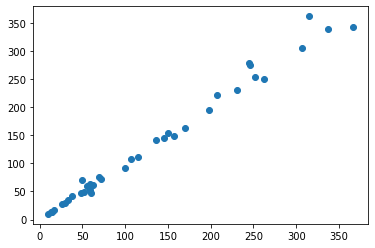

In [251]:
# Check for homoscadacity
plt.scatter(y_pred, y_test)

#### Eventhough it looks like our model is performing very well, there is lot of shortcomings to our simple model. Remember we have the monthly low and high values of the stock, the closing price will always be within that range so the model may achieve great accuracies but in real time we won't have the open, high, low values readily available beforehand to make predictions for closing price, also we haven't brought the time component into it so far.

### <b> Prophet

In [352]:
dfp = df[['Date','Close']]
split_date = '2018-06-01'
df_train = df.loc[dfp['Date'] <= split_date].copy()
df_test = df.loc[dfp['Date'] > split_date].copy()

In [354]:
# Setup and train model and fit
model = Prophet()
model.fit(df_train.reset_index() \
              .rename(columns={'Date':'ds',
                               'Close':'y'}))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [356]:
# Predict on training set with model
df_test_fcst = model.predict(df=df_test.reset_index() \
                                   .rename(columns={'Date':'ds'}))

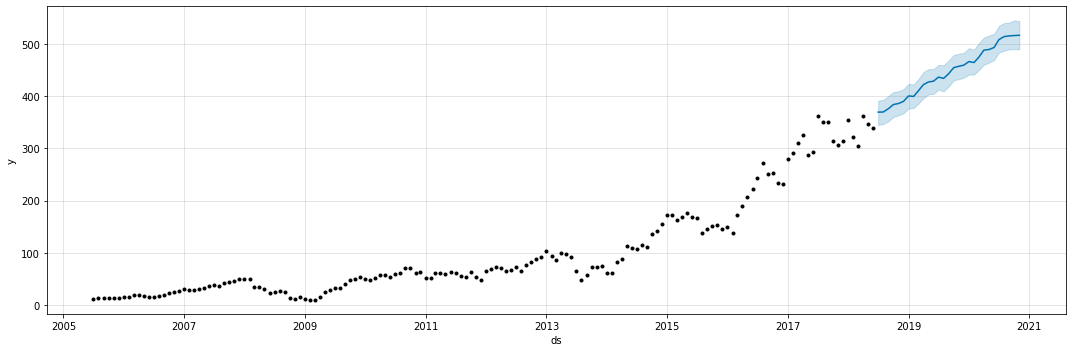

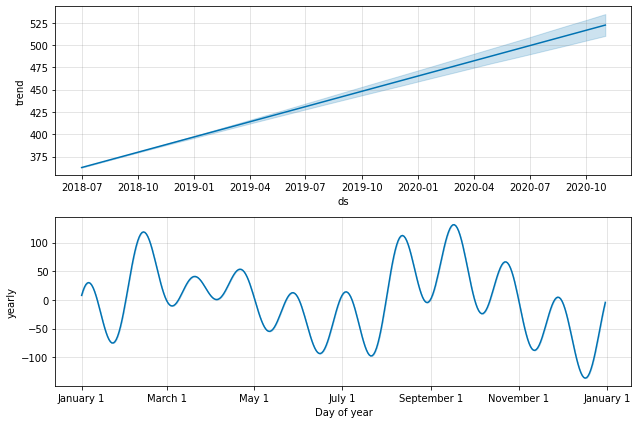

In [357]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(df_test_fcst,
                 ax=ax)
plt.show()

# Plot the components of the model
fig = model.plot_components(df_test_fcst)

### **Moving Average**

### A moving average much better than a naive forecast ($\hat{y}_t = y_{t-1}$). A **moving average** is the average of previous $k$ values. <br>  $\hat{y}_t = \frac{1}{k} \displaystyle\sum^{k}_{n=1} y_{t-n}$

In [339]:
# function for calculating moving average

def moving_average(series, n):
  
  """
  Calculate average of last n observation
  """
  
  return round(np.average(series[-n:]),2)

moving_average(df['OHL'],12) # prediction for next month closing price using observed previous 12 months data

28.49

### Unfortunately we can make only one prediction, to make further predictions we need to have the actual observed values. However moving average can be used to identify the trends by smoothing the time series using a pandas implementation [`DataFrame.rolling(window).mean()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html).

In [255]:
# function for plotting moving average

def ma(series, window, plot_intervals=False):

  """
  series - dataframe column with timeseries
  window - rolling window size
  """

  rolling_mean = series.rolling(window=window).mean()

  plt.figure(figsize=(20,5))
  plt.title('Moving average \n window size = {}'.format(window))
  plt.plot(df['Date'], rolling_mean, "g", label = "Rolling mean trend")
  
  # plotting confidence intervals
  if plot_intervals:
    mae = mean_absolute_error(series[window:], rolling_mean[window:])
    deviation = np.std(series[window] - rolling_mean[window:])
    lower_bound = rolling_mean - (mae + deviation)
    upper_bound = rolling_mean + (mae + deviation)
    plt.plot(df['Date'], lower_bound, "r--", label = "Upper/Lower bounds")
    plt.plot(df['Date'], upper_bound, "r--")
  
  plt.plot(df['Date'], series, label = "Actual values")
  plt.legend(loc="upper left")
  plt.grid(True)
  plt.show()

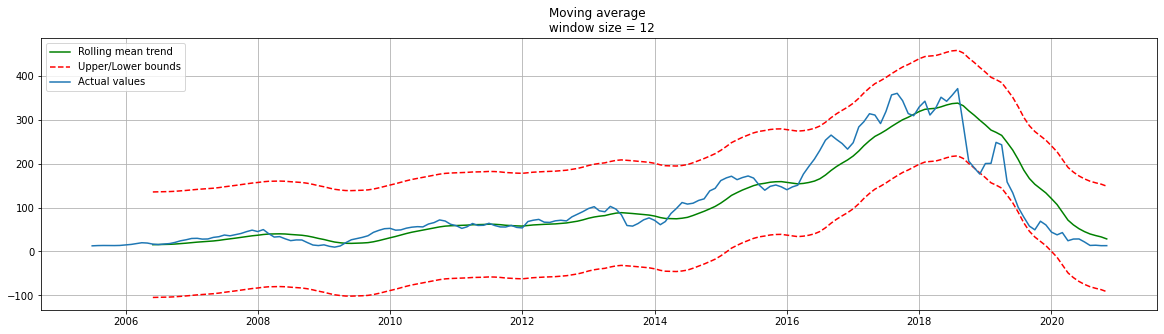

In [256]:
# plotting 12 months moving average 

ma(df['OHL'],12, plot_intervals=True) # smoothing by previous 12 months

In [257]:
# function that returns weighted moving average
def wma(series, weights):
  """
  calculate weighted moving average of the series
  """
  result = 0.0
  for w in range(len(weights)):
    result += series.iloc[-w-1] * weights[w]
    return float(result)

wma(df['OHL'], weights = [0.5, 0.3, 0.2])

6.585

### Now let's extend this concept of weighted averages to exponentially weighted moving averages

### **Exponentially weighted moving averages** weights all the available observations while exponentially decreasing the weights as we move back $k$ values 

## $$\hat{y}_{t+1} = \alpha \cdot y_t + \alpha(1-\alpha) \cdot y_{t-1} + \alpha(1-\alpha)^2 \cdot y_{t-2} + \alpha(1-\alpha)^3 \cdot y_{t-3} + .... $$

## $$ \hat{y}_{t+1} = \alpha \cdot y_t + (1-\alpha) \cdot \hat{y}_t $$

In [258]:
def exponential_smoothing(series, alpha):
  """
  series - dataframe column with timeseries
  alpha - smoothing parameter
  """
  result = [series[0]]
  for n in range(len(series)):
    result.append(alpha * series[n] + (1 - alpha) * result[n-1])
  return result

In [259]:
def ema(series, alphas):
  """
  series - dataframe colummn with time series
  alpha - smoothing parameters
  """
  with plt.style.context('seaborn-white'):
    plt.figure(figsize=(20,5))
    for alpha in alphas:
      plt.plot(exponential_smoothing(series, alpha), label = "Alpha{}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.legend(loc="best")
    plt.grid(True)


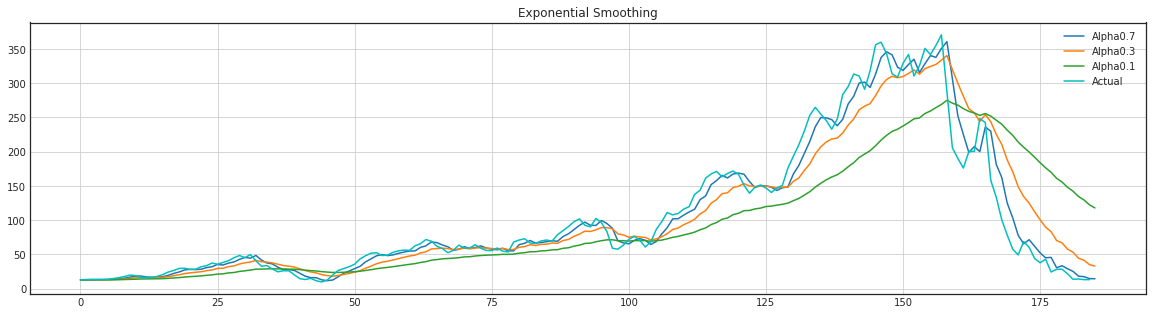

In [260]:
ema(df['OHL'], [0.7, 0.3, 0.1])

## <b> Double exponential smoothing (Holt's linear trend method)

### So far we were able to make just one prediction, clearly which is isn't enough. Double exponential smooothing (Holt's linear trend method) is one such way to overcome this limitation. It has two components, intercept $l$ and slope $b$
## $$\ell_x = \alpha y_x + (1-\alpha)(\ell_{x-1} + b_{x-1})$$
## $$\ b_x = \beta (\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1} $$
## $$\hat{y}_{x+1} = \ell_x + \ b_x  $$

### The final prediction is the sum of the model values of the intercept and trend.


In [261]:
def double_exponential_smoothing(series, horizon, alpha, beta):
  """
  series - dataframe column with timeseries
  alpha - smoothing parameter for level
  beta - smoothing parameter for trend
  """
  # first value is same as series
  result = [series[0]]
  for n in range(1, len(series)+horizon):
      if n == 1:
          level, trend = series[0], series[1] - series[0]
      if n >= len(series): 
          value = result[-1]
      else:
          value = series[n]
      last_level, level = level, alpha*value + (1-alpha)*(level+trend)
      trend = beta*(level-last_level) + (1-beta)*trend
      result.append((level+trend).round(2))
  print(result[-horizon:])
  return result

In [262]:
def dema(series, horizon, alpha, beta):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataframe column with timeseries
        alphas - smoothing parameters for level
        betas - smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 5))
        plt.plot(double_exponential_smoothing(series, horizon, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

### Predictions by various combinations of alphas and betas

[35.9, 39.75, 43.6, 47.45, 51.3, 55.15]
[24.65, 23.63, 22.61, 21.59, 20.57, 19.55]
[19.35, 15.49, 11.63, 7.77, 3.91, 0.05]
[12.67, 5.52, -1.63, -8.78, -15.93, -23.08]
[9.11, 2.22, -4.67, -11.56, -18.45, -25.34]
[34.11, 40.3, 46.49, 52.68, 58.87, 65.06]


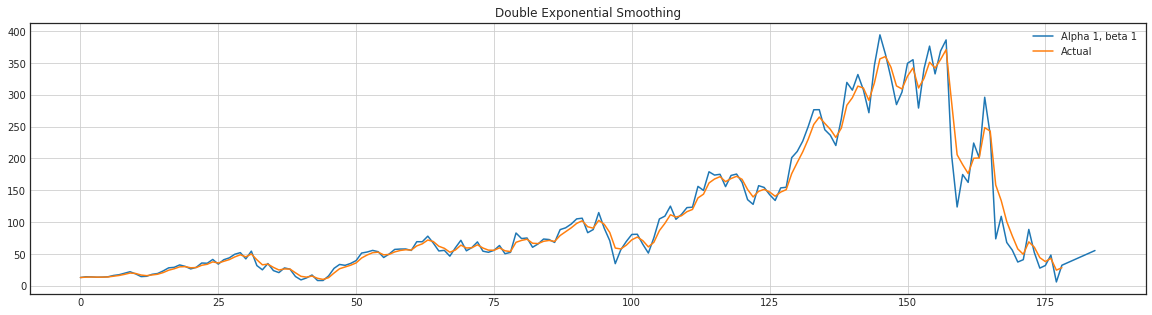

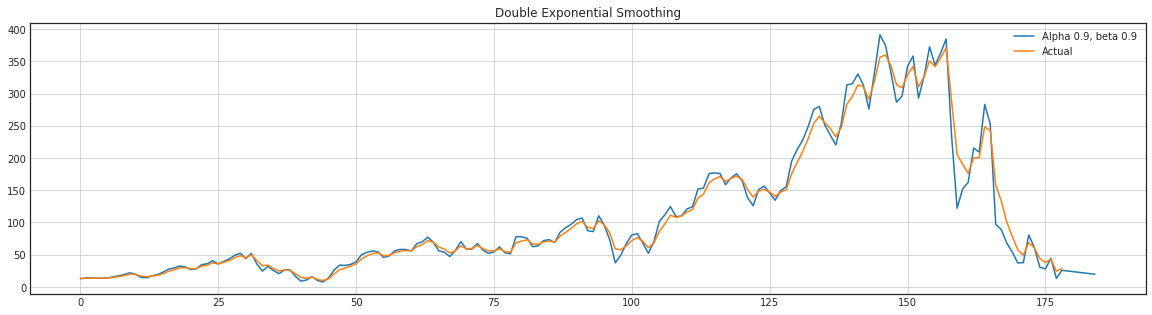

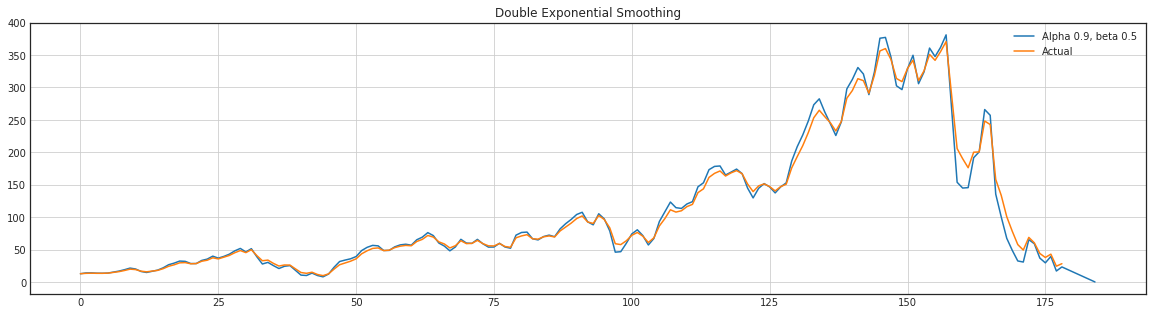

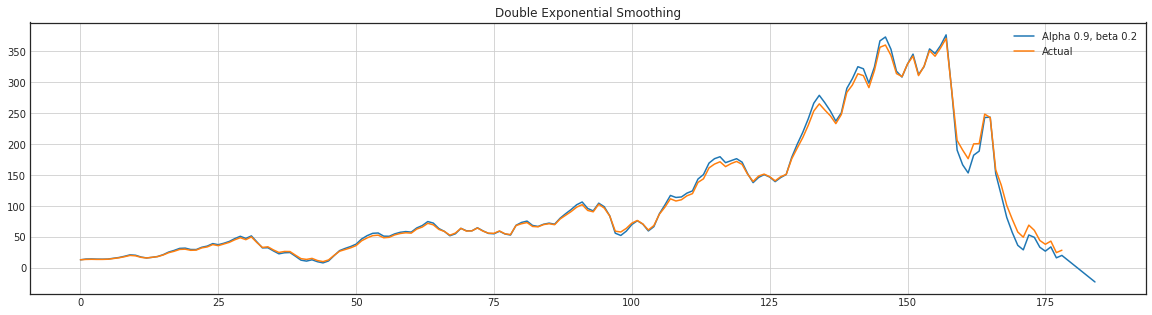

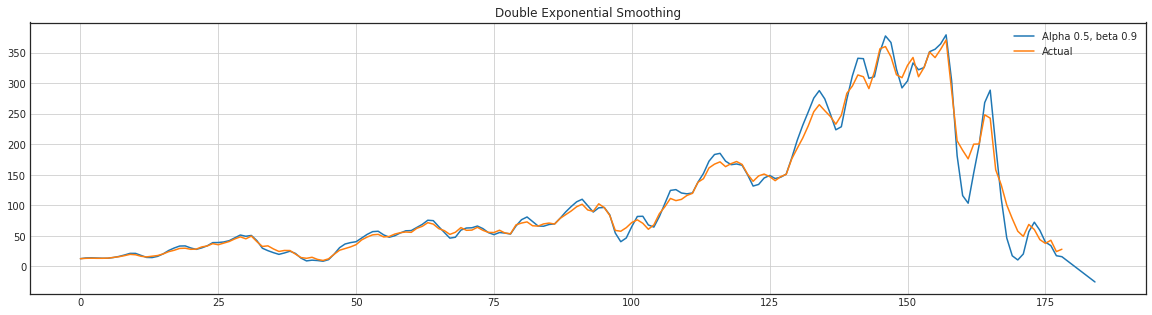

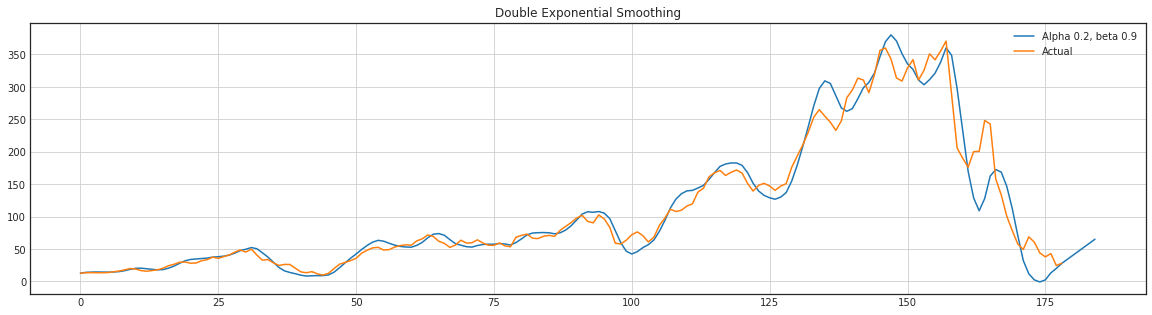

In [307]:
# Try multiple values of alpha and beta

combinations = [(1,1), (0.9,0.9), (0.9, 0.5), (0.9, 0.2), (0.5, 0.9), (0.2, 0.9)]
for alpha, beta in combinations:
  dema(df['OHL'][0:179], 6, alpha, beta)

### Any time series need to be stationary to make predictions. A process is said to be stationary if it's statistical properties like mean and variance don't change over time. One way to check for stationarity is through visual inspections or one can conduct a [Dickey-Fuller test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test). The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.


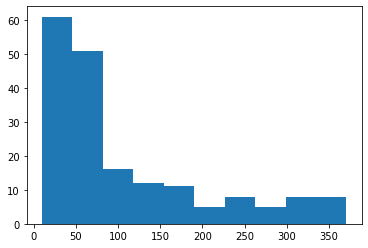

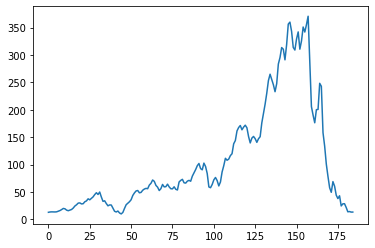

In [265]:
# visual inspection

x = df['OHL']
plt.hist(x)
plt.show()
plt.plot(x)
plt.show()

In [266]:
# Implement Dickey-Fuller test

x = df['OHL'].values
result = adfuller(x)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.532432
p-value: 0.107781
Critical Values:
	1%: -3.469
	5%: -2.878
	10%: -2.576


### ADF statistic is greater than all our critical values, thus we have failed to reject the null hypothesis. It's confirmed that our time series model is not stationary. We'll make it stationary to build ARIMA model and then make future predictions.

### <b><u> Getting rid of non stationarity

In [267]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

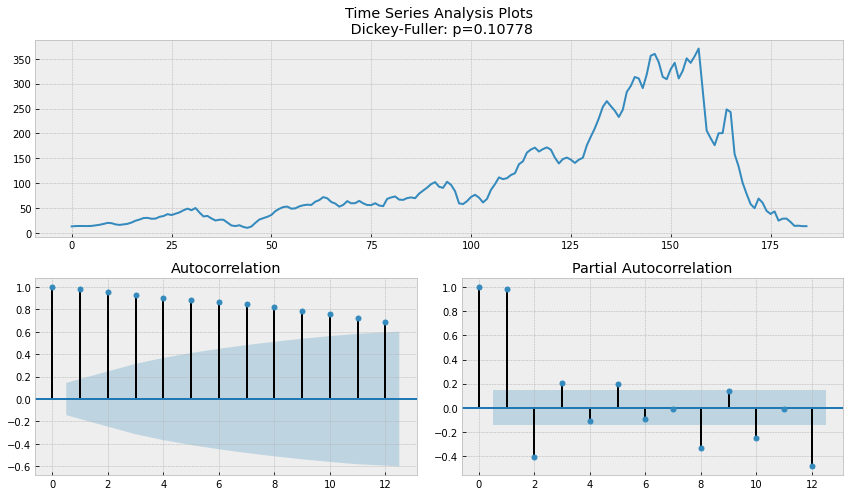

In [268]:
tsplot(df['OHL'], lags=12)

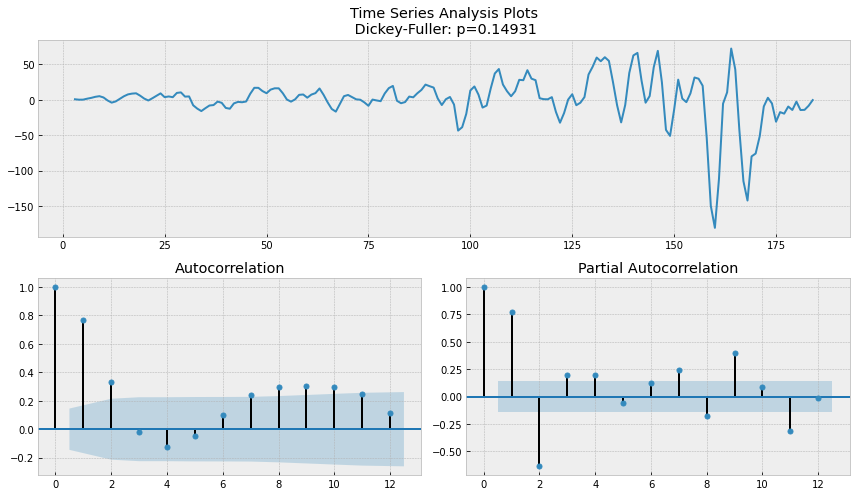

In [269]:
diff = df['OHL'] - df['OHL'].shift(3)
tsplot(diff[3:], lags=12)

#### The autocorrelation function still has too many significant lags. To remove them, we'll take first differences, subtracting the series from itself with lag 1

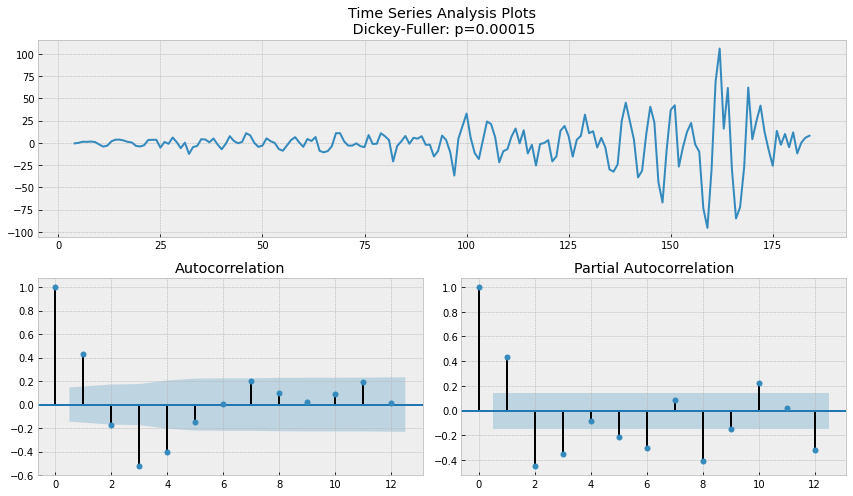

In [270]:
diff = diff - diff.shift(1)
tsplot(diff[3+1:], lags=12)

*   p = 2
*   d = 1
*   q = 2




### <b> ARIMA Implementation

                             ARIMA Model Results                              
Dep. Variable:                  D.OHL   No. Observations:                  180
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -761.337
Method:                       css-mle   S.D. of innovations             16.207
Date:                Mon, 27 Dec 2021   AIC                           1534.673
Time:                        15:56:06   BIC                           1553.831
Sample:                             1   HQIC                          1542.441
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0027      0.008     -0.335      0.738      -0.019       0.013
ar.L1.D.OHL     1.1550      0.060     19.132      0.000       1.037       1.273
ar.L2.D.OHL    -0.6713      0.055    -12.316    

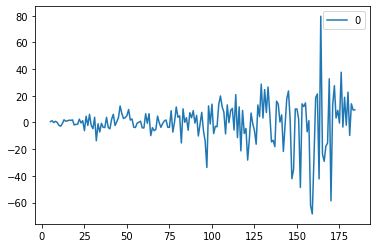

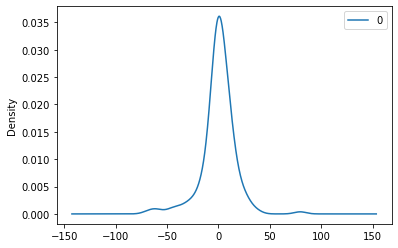

                0
count  180.000000
mean     0.047990
std     16.322122
min    -68.534048
25%     -4.076029
50%      0.757665
75%      7.482914
max     79.597588


In [271]:
# fit model
model = ARIMA(diff[4:], order=(2,1,2))
model = model.fit()
# summary of fit model
print(model.summary())
# line plot of residuals
residuals = pd.DataFrame(model.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [272]:
diff = pd.Series(data=diff[5:])

In [273]:
def plotARIMA(series, model, n_steps, d=1):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted ARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    # data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on d steps from the beginning
    error = mean_absolute_percentage_error(diff[d:], data['arima_model'][d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.plot(diff, label="actual")
    plt.legend()
    plt.grid(True);

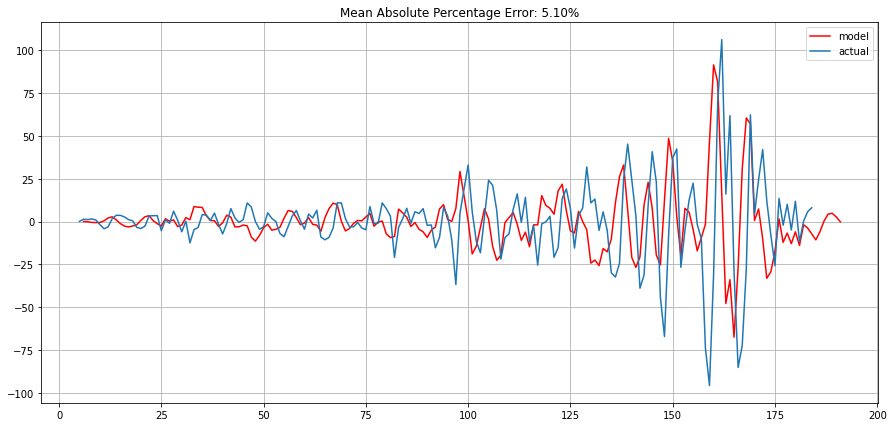

In [274]:
plotARIMA(diff, model, 6)

#### MAPE of 5.10% is not bad, we've got an accuracy of 94.90%

# Use lags as additional features

In [359]:
# Adding the lag of the target variable from 6 steps back up to 24
for i in range(1, 13):
    df["lag_{}".format(i)] = df.Close.shift(i) 

In [360]:
df.tail()

,Date,Open,High,Low,Close,OHL,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
180,2020-07-01,25.60,28.30,11.10,11.95,21.67,25.60,26.85,27.95,22.45,34.55,39.20,46.95,68.30,70.45,41.45,59.50,91.30
181,2020-08-01,12.00,17.16,11.85,14.37,13.67,11.95,25.60,26.85,27.95,22.45,34.55,39.20,46.95,68.30,70.45,41.45,59.50
182,2020-09-01,14.30,15.34,12.75,13.15,14.13,14.37,11.95,25.60,26.85,27.95,22.45,34.55,39.20,46.95,68.30,70.45,41.45
183,2020-10-01,13.30,14.01,12.11,12.42,13.14,13.15,14.37,11.95,25.60,26.85,27.95,22.45,34.55,39.20,46.95,68.30,70.45
184,2020-11-01,12.41,14.90,12.21,14.67,13.17,12.42,13.15,14.37,11.95,25.60,26.85,27.95,22.45,34.55,39.20,46.95,68.30


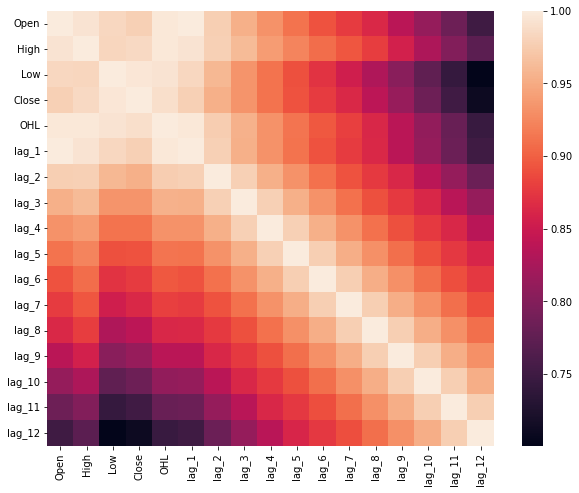

In [362]:
# correlation between features
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr())

#### To reduce multicollinearity we can use regularization that means to keep all the features but reducing the magnitude of the coefficients of the model. This is a good solution when each predictor contributes to predict the dependent variable.

In [283]:
# date as index
df = df.set_index('Date')

In [284]:
# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [285]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    scaler = StandardScaler()
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [286]:
# choose appropriate dependent and independent variables
y = df.dropna().Close
X = df.dropna().drop(['Close'], axis=1)

# split the dataset into train and test sets
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.2)

### <b> Implementing linear regression model

In [287]:
# initialize and fit linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [288]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

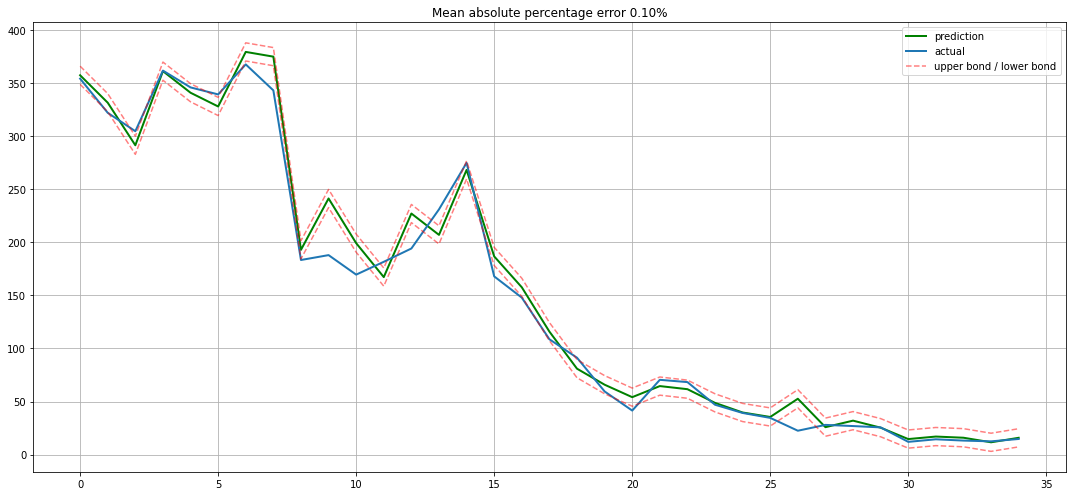

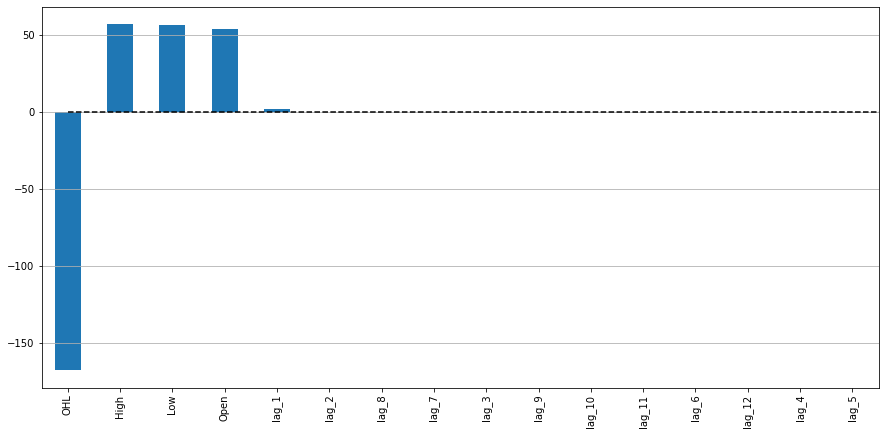

In [289]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

### <b> Implementing ridge regression

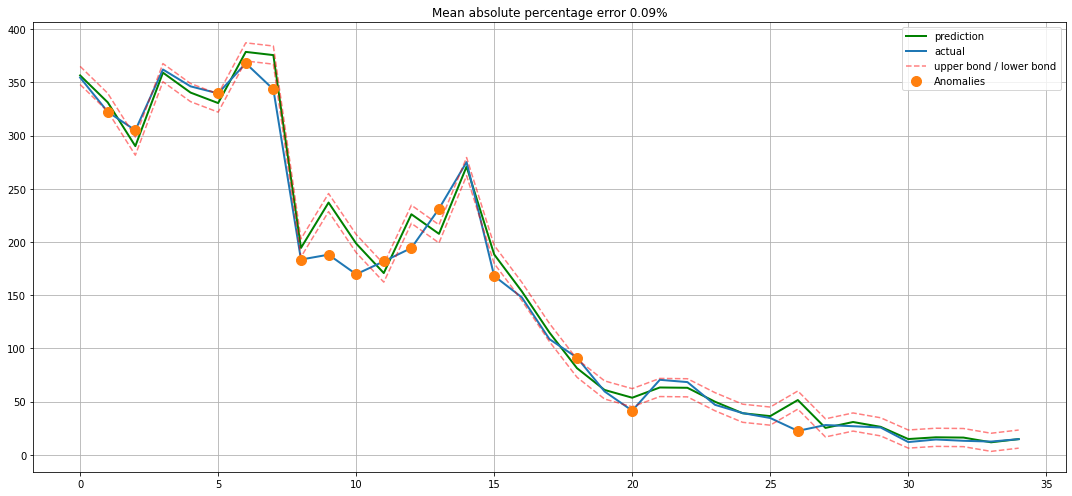

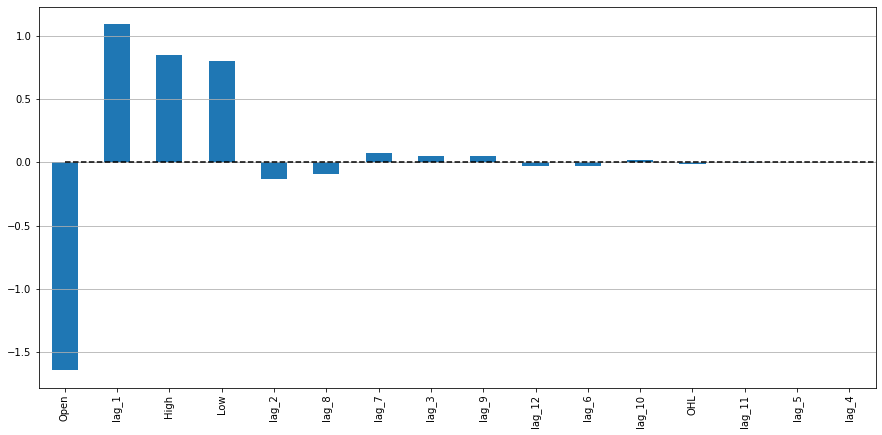

In [293]:
ridge = RidgeCV(cv=tscv)
ridge.fit(X_train, y_train)

plotModelResults(ridge, 
                 X_train, 
                 X_test, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

### <b> Implementing lasso regression


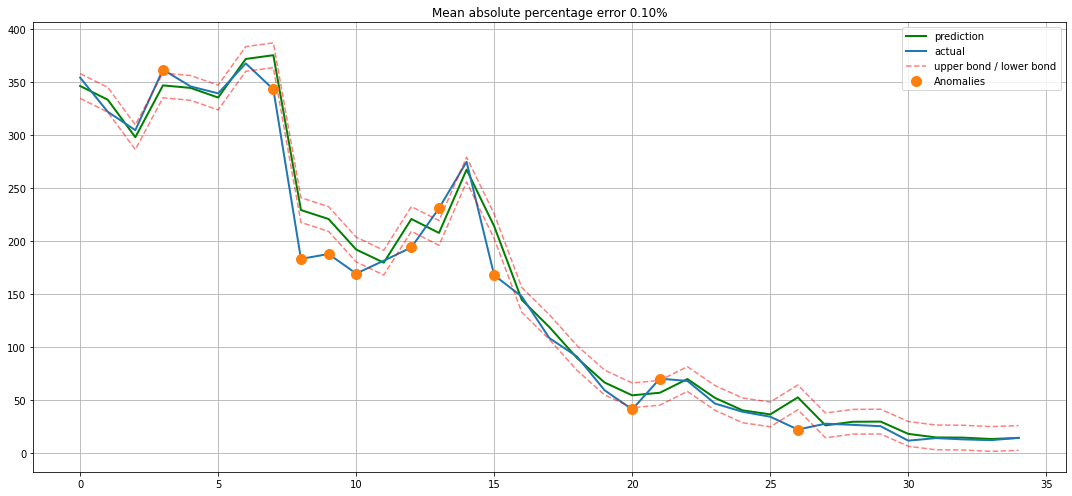

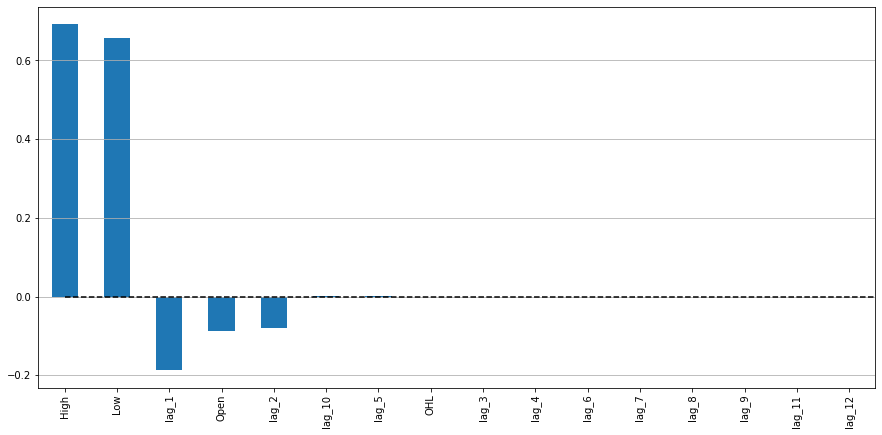

In [294]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train, y_train)

plotModelResults(lasso, 
                 X_train, 
                 X_test, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)

### <b> Implementing elasticnet regression


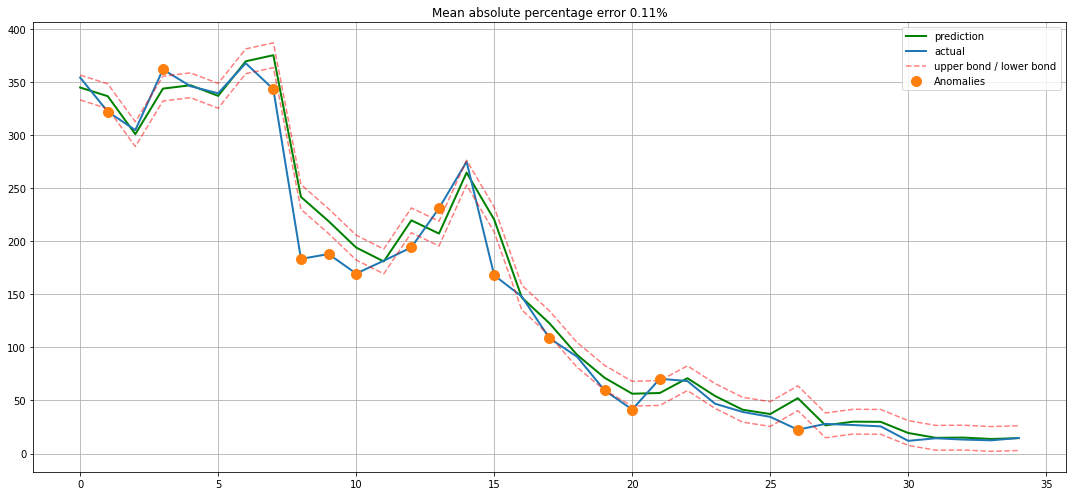

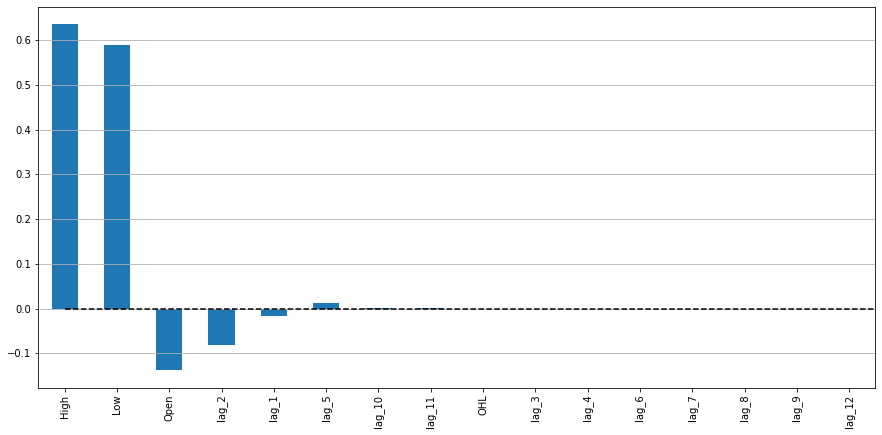

In [304]:
elasticnet = ElasticNetCV(cv=tscv)
elasticnet.fit(X_train, y_train)

plotModelResults(elasticnet, 
                 X_train, 
                 X_test, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(elasticnet)

### <b> Model pipeline

In [296]:
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred

### <b> Implementing XGBoost Regression model


In [298]:
model = XGBRegressor()
param_grid = {
    'n_estimators': [400, 700, 1000],
    'colsample_bytree': [0.7, 0.8],
    'max_depth': [15,20,25],
    'reg_alpha': [1.1, 1.2, 1.3],
    'reg_lambda': [1.1, 1.2, 1.3],
    'subsample': [0.7, 0.8, 0.9]
}

model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, 
                                 param_grid, cv=tscv)

# Root Mean Squared Error
print(np.sqrt(-model.best_score_))
print(model.best_params_)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
[16:17:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
60.957527037546924
{'colsample_bytree': 0.7, 'max_depth': 15, 'n_estimators': 1000, 'reg_alpha': 1.1, 'reg_lambda': 1.2, 'subsample': 0.7}


In [299]:
xgb = model.best_estimator_

[16:18:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:18:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:18:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:18:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:18:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


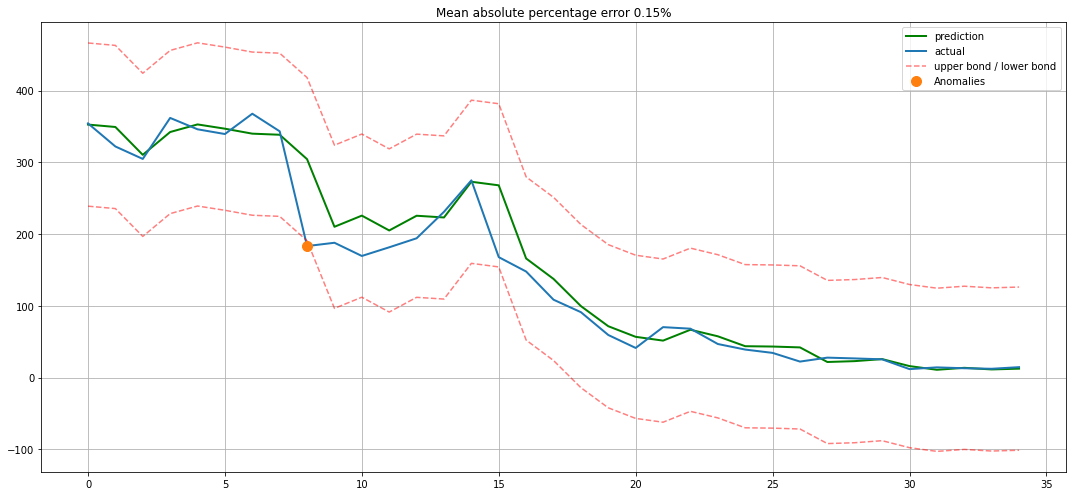

In [300]:
plotModelResults(xgb, 
                 X_train, 
                 X_test, 
                 plot_intervals=True, plot_anomalies=True)